<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# K-Nearest Neighbors


Estimated time needed: **25** minutes
    

## Objectives

After completing this lab you will be able to:

* Use K Nearest neighbors to classify data


In this Lab you will load a customer dataset, fit the data, and use K-Nearest Neighbors to predict a data point. But what is **K-Nearest Neighbors**?


**K-Nearest Neighbors** is a supervised learning algorithm. Where the data is 'trained' with data points corresponding to their classification. To predict the class of a given data point, it takes into account the classes of the 'K' nearest data points and chooses the class in which the majority of the 'K' nearest data points belong to as the predicted class.


### Here's an visualization of the K-Nearest Neighbors algorithm.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/images/KNN_Diagram.png">


In this case, we have data points of Class A and B. We want to predict what the star (test data point) is. If we consider a k value of 3 (3 nearest data points), we will obtain a prediction of Class B. Yet if we consider a k value of 6, we will obtain a prediction of Class A.


In this sense, it is important to consider the value of k. Hopefully from this diagram, you should get a sense of what the K-Nearest Neighbors algorithm is. It considers the 'K' Nearest Neighbors (data points) when it predicts the classification of the test point.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#about_dataset">About the dataset</a></li>
        <li><a href="#visualization_analysis">Data Visualization and Analysis</a></li>
        <li><a href="#classification">Classification</a></li>
    </ol>
</div>
<br>
<hr>


In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])



Let's load required libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

<div id="about_dataset">
    <h2>About the dataset</h2>
</div>


Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case. 

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns. 

The target field, called __custcat__, has four possible values that correspond to the four customer groups, as follows:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service

Our objective is to build a classifier, to predict the class of unknown cases. We will use a specific type of classification called K nearest neighbour.


Let's download the dataset. To download the data, we will use !wget to download it from IBM Object Storage.


In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())


In [4]:
path="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv"

__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


### Load Data From CSV File  


In [5]:
await download(path, 'teleCust1000t.csv')
            

In [6]:
df = pd.read_csv('teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


<div id="visualization_analysis">
    <h2>Data Visualization and Analysis</h2> 
</div>


#### Let’s see how many of each class is in our data set 


In [7]:
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

#### 281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers


You can easily explore your data using visualization techniques:


array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

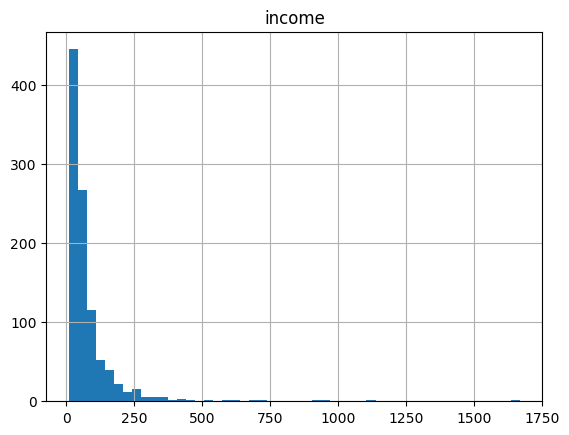

In [8]:
df.hist(column='income', bins=50)

### Feature set


Let's define feature sets, X:


In [9]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:


In [10]:
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)
X[0:5]


array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

What are our labels?


In [11]:
y = df['custcat'].values
y[0:5]

array([1, 4, 3, 1, 3], dtype=int64)

### Train Test Split  
Out of Sample Accuracy is the percentage of correct predictions that the model makes on data that the model has NOT been trained on. Doing a train and test on the same dataset will most likely have low out-of-sample accuracy, due to the likelihood of our model overfitting.

It is important that our models have a high, out-of-sample accuracy, because the purpose of any model, of course, is to make correct predictions on unknown data. So how can we improve out-of-sample accuracy? One way is to use an evaluation approach called Train/Test Split.
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 

This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that has been used to train the model. It is more realistic for the real world problems.


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 11) (800,)
Test set: (200, 11) (200,)


In [21]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,3.0,31.0,1.0,4.0,23.0,4.0,4.0,0.0,0.0,5.0
1,2.0,41.0,46.0,1.0,14.0,47.0,2.0,11.0,0.0,0.0,5.0
2,1.0,19.0,33.0,1.0,11.0,22.0,1.0,3.0,0.0,0.0,5.0
3,2.0,3.0,37.0,0.0,13.0,24.0,1.0,3.0,0.0,1.0,1.0
4,3.0,31.0,34.0,0.0,9.0,105.0,4.0,7.0,0.0,1.0,4.0


## Normalize Data 


Data Standardization gives the data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on the distance of data points:


In [13]:
X_train_norm = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_train_norm[0:5]

array([[-1.28618818e+00, -1.53085556e+00, -8.49354628e-01,
         1.00752834e+00, -7.46393214e-01, -4.83608776e-01,
         1.12305195e+00, -7.02283455e-01, -2.23313158e-01,
        -1.01005050e+00,  1.83304333e+00],
       [-4.79805457e-02,  2.51253999e-01,  3.44957012e-01,
         1.00752834e+00,  2.45326718e-01, -2.71543263e-01,
        -5.40728715e-01, -1.25385370e-04, -2.23313158e-01,
        -1.01005050e+00,  1.83304333e+00],
       [-1.28618818e+00, -7.80493639e-01, -6.90113076e-01,
         1.00752834e+00, -5.21892614e-02, -4.92444839e-01,
        -1.37261905e+00, -8.02591750e-01, -2.23313158e-01,
        -1.01005050e+00,  1.83304333e+00],
       [-4.79805457e-02, -1.53085556e+00, -3.71629972e-01,
        -9.92527915e-01,  1.46154725e-01, -4.74772713e-01,
        -1.37261905e+00, -8.02591750e-01, -2.23313158e-01,
         9.90049504e-01, -9.33814526e-01],
       [ 1.19022709e+00, -2.17722200e-01, -6.10492300e-01,
        -9.92527915e-01, -2.50533248e-01,  2.40948394e-01,
  

In [22]:
pd.DataFrame(X_train_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.286188,-1.530856,-0.849355,1.007528,-0.746393,-0.483609,1.123052,-0.702283,-0.223313,-1.010051,1.833043
1,-0.047981,0.251254,0.344957,1.007528,0.245327,-0.271543,-0.540729,-0.000125,-0.223313,-1.010051,1.833043
2,-1.286188,-0.780494,-0.690113,1.007528,-0.052189,-0.492445,-1.372619,-0.802592,-0.223313,-1.010051,1.833043
3,-0.047981,-1.530856,-0.371630,-0.992528,0.146155,-0.474773,-1.372619,-0.802592,-0.223313,0.990050,-0.933815
4,1.190227,-0.217722,-0.610492,-0.992528,-0.250533,0.240948,1.123052,-0.401359,-0.223313,0.990050,1.141329


<div id="classification">
    <h2>Classification</h2>
</div>


<h3>K nearest neighbor (KNN)</h3>


#### Import library 


Classifier implementing the k-nearest neighbors vote.


In [23]:
from sklearn.neighbors import KNeighborsClassifier

### Training

Let's start the algorithm with k=4 for now:


In [24]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_norm,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [25]:
X_test_norm = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
X_test_norm[0:5]

array([[-1.13100942, -0.93533648, -0.93817795,  1.02020406, -0.36233308,
         0.17102716, -0.58336825,  0.00666863, -0.21707238, -1.13967126,
         1.97590703],
       [-1.13100942, -1.44823286, -0.13972863, -0.98019606,  0.03474427,
        -0.50017376, -0.58336825, -0.56492821, -0.21707238, -1.13967126,
        -0.90337462],
       [-1.13100942, -0.51569399,  1.53701494,  1.02020406, -0.56087175,
         0.45499678,  0.9619781 , -0.75546048, -0.21707238,  0.87744601,
         1.25608662],
       [-1.13100942, -0.74882871, -0.85833302,  1.02020406, -1.15648777,
        -0.70669712,  0.9619781 , -0.85072662, -0.21707238, -1.13967126,
         0.53626621],
       [-1.13100942,  0.51009876, -1.01802288,  1.02020406, -0.75941043,
         0.17102716,  1.73465128, -0.75546048, -0.21707238, -1.13967126,
         1.25608662]])

### Predicting
We can use the model to make predictions on the test set:


In [26]:
yhat = neigh.predict(X_test_norm)
yhat[0:5]

array([3, 1, 3, 2, 4], dtype=int64)

### Accuracy evaluation
In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.


In [27]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train_norm)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5475
Test set Accuracy:  0.33


## Practice
Can you build the model again, but this time with k=6?


In [30]:
# write your code here
k = 6
#Train Model and Predict  
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train_norm,y_train)
yhat6 = neigh6.predict(X_test_norm)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train_norm)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

Train set Accuracy:  0.5125
Test set Accuracy:  0.335


<details><summary>Click here for the solution</summary>

```python
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train_norm,y_train)
yhat6 = neigh6.predict(X_test_norm)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train_norm)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

```

</details>



#### What about other K?
K in KNN, is the number of nearest neighbors to examine. It is supposed to be specified by the user. So, how can we choose right value for K?
The general solution is to reserve a part of your data for testing the accuracy of the model. Then choose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

We can calculate the accuracy of KNN for different values of k.


In [31]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_norm,y_train)
    yhat=neigh.predict(X_test_norm)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.32 , 0.315, 0.335, 0.33 , 0.34 , 0.335, 0.35 , 0.34 , 0.335])

#### Plot the model accuracy for a different number of neighbors.


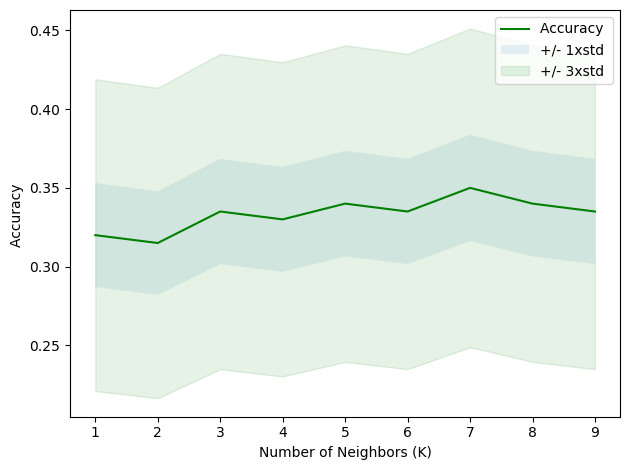

In [32]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [33]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.35 with k= 7


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork1047-2023-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://www.ibm.com/cloud/watson-studio?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork1047-2023-01-01">Watson Studio</a>



### Thank you for completing this lab!




## Author

Saeed Aghabozorgi


### Other Contributors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/" target="_blank">Joseph Santarcangelo</a>




## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2023-05-29  | 2.5  | Anita Verma  | Changed the sequence for Data Analysis |
| 2021-01-21  | 2.4  | Lakshmi  | Updated sklearn library |
| 2020-11-20  | 2.3  | Lakshmi  | Removed unused imports |
| 2020-11-17  | 2.2  | Lakshmi  | Changed plot function of KNN |
| 2020-11-03  | 2.1  | Lakshmi  | Changed URL of csv |
| 2020-08-27  | 2.0  | Lavanya  |  Moved lab to course repo in GitLab |
|   |   |   |   |
|   |   |   |   |


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
